In [1]:
import torch
from transformers import LongformerForSequenceClassification, LongformerTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import pandas as pd
import os

# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\DreamDreamer\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
from datasets import load_dataset, ClassLabel

# 从 CSV 加载数据
#data_files = {"data": "../datasets/datasets.csv"}
data_files = {"data": "../datasets/resampled_output.csv"}
dataset = load_dataset("csv", data_files=data_files)

# 将标签中的 . 替换为 _
def replace_dot_with_underscore(example):
    return {"label": example["label"].replace(".", "_")}
dataset = dataset.map(replace_dot_with_underscore)

# 获取唯一的标签值
unique_labels = sorted(set(dataset["data"]["label"]))
print("唯一的标签值:", unique_labels)

# 将 label 列转换为 ClassLabel 类型
dataset = dataset.cast_column("label", ClassLabel(names=unique_labels))

# 打印数据集信息
print(dataset)

Generating data split: 16409 examples [00:00, 21278.17 examples/s]
Map: 100%|██████████| 16409/16409 [00:01<00:00, 13882.94 examples/s]


唯一的标签值: ['cs_AI', 'cs_CE', 'cs_DS', 'cs_IT', 'cs_NE', 'cs_PL', 'cs_SY', 'cs_cv', 'math_AC', 'math_GR', 'math_ST']


Casting the dataset: 100%|██████████| 16409/16409 [00:00<00:00, 221793.62 examples/s]

DatasetDict({
    data: Dataset({
        features: ['review_id', 'keywords', 'keysentences', 'abstract', 'label'],
        num_rows: 16409
    })
})


In [3]:
# 将keywords、keysentences和abstract拼接成text
def concatenate_text(example):
    text = ' '.join([str(example['keywords']), str(example['keysentences']), str(example['abstract'])])
    return {'text': text}
dataset = dataset.map(concatenate_text)

# 划分训练集和验证集，80%训练，20%验证
dataset = dataset['data'].train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = dataset['train']
eval_dataset = dataset['test']

Map: 100%|██████████| 16409/16409 [00:01<00:00, 10856.51 examples/s]


In [4]:
# 获取分类个数
num_classes = len(train_dataset.features['label'].names)
print(f"Number of classes: {num_classes}")
# 加载预训练的Longformer模型和tokenizer
model_name = 'allenai/longformer-base-4096'
tokenizer = LongformerTokenizer.from_pretrained(model_name)
model = LongformerForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
model.to(device)

Number of classes: 11


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
          

In [5]:
#数据预处理
def encode_batch(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=1024)

encoded_train_dataset = train_dataset.map(encode_batch, batched=True, batch_size=32)
encoded_eval_dataset = eval_dataset.map(encode_batch, batched=True, batch_size=32)

Map: 100%|██████████| 3282/3282 [00:18<00:00, 177.28 examples/s]


In [6]:

#设置参数，用Trainer（）创造实例
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=5e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    evaluation_strategy='epoch',
    logging_dir='./logs',
)

# 创建Trainer实例
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()},
)

c:\Users\DreamDreamer\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\DreamDreamer\AppData\Local\Temp\ipykernel_61920\3960417624.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [7]:
#模型训练
trainer.train()

  3%|▎         | 500/19692 [06:53<5:12:01,  1.03it/s]

{'loss': 2.0403, 'grad_norm': 16.27923583984375, 'learning_rate': 5e-05, 'epoch': 0.08}


  5%|▌         | 1000/19692 [15:20<5:26:31,  1.05s/it]

{'loss': 1.5884, 'grad_norm': 33.65449523925781, 'learning_rate': 4.869737390579409e-05, 'epoch': 0.15}


  8%|▊         | 1500/19692 [23:10<4:42:10,  1.07it/s] 

{'loss': 1.4568, 'grad_norm': 28.631946563720703, 'learning_rate': 4.7394747811588166e-05, 'epoch': 0.23}


 10%|█         | 2000/19692 [31:41<5:25:43,  1.10s/it] 

{'loss': 1.3675, 'grad_norm': 17.333805084228516, 'learning_rate': 4.6092121717382245e-05, 'epoch': 0.3}


 13%|█▎        | 2500/19692 [39:32<4:02:49,  1.18it/s] 

{'loss': 1.3257, 'grad_norm': 10.732717514038086, 'learning_rate': 4.4789495623176324e-05, 'epoch': 0.38}


 15%|█▌        | 3000/19692 [46:31<3:47:49,  1.22it/s] 

{'loss': 1.3783, 'grad_norm': 70.05255126953125, 'learning_rate': 4.348686952897041e-05, 'epoch': 0.46}


 18%|█▊        | 3500/19692 [53:18<3:31:19,  1.28it/s] 

{'loss': 1.3407, 'grad_norm': 19.994394302368164, 'learning_rate': 4.218424343476449e-05, 'epoch': 0.53}


 20%|██        | 4000/19692 [59:59<3:26:23,  1.27it/s] 

{'loss': 1.3914, 'grad_norm': 87.52894592285156, 'learning_rate': 4.088161734055857e-05, 'epoch': 0.61}


 23%|██▎       | 4500/19692 [1:06:41<3:19:16,  1.27it/s] 

{'loss': 1.1748, 'grad_norm': 108.53588104248047, 'learning_rate': 3.9578991246352645e-05, 'epoch': 0.69}


 25%|██▌       | 5000/19692 [1:13:21<3:12:27,  1.27it/s] 

{'loss': 1.2892, 'grad_norm': 0.19211001694202423, 'learning_rate': 3.827636515214673e-05, 'epoch': 0.76}


 28%|██▊       | 5500/19692 [1:20:01<3:05:03,  1.28it/s] 

{'loss': 1.233, 'grad_norm': 0.1348242610692978, 'learning_rate': 3.697373905794081e-05, 'epoch': 0.84}


 30%|███       | 6000/19692 [1:26:42<2:59:24,  1.27it/s] 

{'loss': 1.2938, 'grad_norm': 16.338918685913086, 'learning_rate': 3.5671112963734895e-05, 'epoch': 0.91}


 33%|███▎      | 6500/19692 [1:33:20<2:50:48,  1.29it/s] 

{'loss': 1.1614, 'grad_norm': 3.542091131210327, 'learning_rate': 3.436848686952897e-05, 'epoch': 0.99}


                                                         
 33%|███▎      | 6564/19692 [1:40:03<2:33:32,  1.43it/s]

{'eval_loss': 1.3059556484222412, 'eval_accuracy': 0.7172455819622182, 'eval_runtime': 345.7963, 'eval_samples_per_second': 9.491, 'eval_steps_per_second': 4.746, 'epoch': 1.0}


 36%|███▌      | 7000/19692 [1:45:44<2:45:39,  1.28it/s]   

{'loss': 1.113, 'grad_norm': 0.7736559510231018, 'learning_rate': 3.306586077532305e-05, 'epoch': 1.07}


 38%|███▊      | 7500/19692 [1:52:25<2:49:51,  1.20it/s] 

{'loss': 1.0721, 'grad_norm': 28.414838790893555, 'learning_rate': 3.176323468111713e-05, 'epoch': 1.14}


 41%|████      | 8000/19692 [1:59:14<2:35:14,  1.26it/s] 

{'loss': 1.2044, 'grad_norm': 0.05428263917565346, 'learning_rate': 3.0460608586911216e-05, 'epoch': 1.22}


 43%|████▎     | 8500/19692 [2:05:59<2:16:48,  1.36it/s] 

{'loss': 0.9568, 'grad_norm': 14.621183395385742, 'learning_rate': 2.9157982492705294e-05, 'epoch': 1.29}


 46%|████▌     | 9000/19692 [2:12:19<2:13:49,  1.33it/s] 

{'loss': 1.1042, 'grad_norm': 19.250259399414062, 'learning_rate': 2.7855356398499376e-05, 'epoch': 1.37}


 48%|████▊     | 9500/19692 [2:18:59<2:09:35,  1.31it/s] 

{'loss': 1.0457, 'grad_norm': 2.374037504196167, 'learning_rate': 2.6552730304293455e-05, 'epoch': 1.45}


 51%|█████     | 10000/19692 [2:25:29<2:03:08,  1.31it/s]

{'loss': 1.0672, 'grad_norm': 154.73023986816406, 'learning_rate': 2.5250104210087537e-05, 'epoch': 1.52}


 53%|█████▎    | 10500/19692 [2:32:01<2:03:13,  1.24it/s]

{'loss': 1.0111, 'grad_norm': 0.10508266091346741, 'learning_rate': 2.394747811588162e-05, 'epoch': 1.6}


 56%|█████▌    | 11000/19692 [2:38:44<1:50:36,  1.31it/s] 

{'loss': 1.0915, 'grad_norm': 0.14329078793525696, 'learning_rate': 2.26448520216757e-05, 'epoch': 1.68}


 58%|█████▊    | 11500/19692 [2:45:27<1:43:50,  1.31it/s] 

{'loss': 0.9286, 'grad_norm': 0.057294320315122604, 'learning_rate': 2.134222592746978e-05, 'epoch': 1.75}


 61%|██████    | 12000/19692 [2:52:29<1:49:14,  1.17it/s] 

{'loss': 0.9553, 'grad_norm': 0.7593856453895569, 'learning_rate': 2.0039599833263862e-05, 'epoch': 1.83}


 63%|██████▎   | 12500/19692 [2:59:15<1:32:33,  1.29it/s]

{'loss': 1.0336, 'grad_norm': 0.9431027770042419, 'learning_rate': 1.873697373905794e-05, 'epoch': 1.9}


 66%|██████▌   | 13000/19692 [3:06:02<1:25:10,  1.31it/s] 

{'loss': 0.9989, 'grad_norm': 0.16075055301189423, 'learning_rate': 1.7434347644852023e-05, 'epoch': 1.98}


                                                          
 67%|██████▋   | 13128/19692 [3:13:36<1:13:37,  1.49it/s]

{'eval_loss': 1.221490740776062, 'eval_accuracy': 0.7678244972577697, 'eval_runtime': 342.5481, 'eval_samples_per_second': 9.581, 'eval_steps_per_second': 4.791, 'epoch': 2.0}


 69%|██████▊   | 13500/19692 [3:18:23<1:19:41,  1.29it/s]   

{'loss': 0.8225, 'grad_norm': 134.46112060546875, 'learning_rate': 1.6131721550646105e-05, 'epoch': 2.06}


 71%|███████   | 14000/19692 [3:25:06<1:18:33,  1.21it/s]

{'loss': 0.8606, 'grad_norm': 0.04376982897520065, 'learning_rate': 1.4829095456440185e-05, 'epoch': 2.13}


 74%|███████▎  | 14500/19692 [3:31:41<1:06:13,  1.31it/s]

{'loss': 0.8441, 'grad_norm': 15.776792526245117, 'learning_rate': 1.3526469362234265e-05, 'epoch': 2.21}


 76%|███████▌  | 15000/19692 [3:38:11<59:18,  1.32it/s]  

{'loss': 0.7593, 'grad_norm': 150.47193908691406, 'learning_rate': 1.2223843268028346e-05, 'epoch': 2.29}


 79%|███████▊  | 15500/19692 [3:44:39<52:54,  1.32it/s]  

{'loss': 0.8067, 'grad_norm': 235.46429443359375, 'learning_rate': 1.0921217173822426e-05, 'epoch': 2.36}


 81%|████████▏ | 16000/19692 [3:51:06<46:22,  1.33it/s]  

{'loss': 0.7587, 'grad_norm': 0.05355658754706383, 'learning_rate': 9.618591079616506e-06, 'epoch': 2.44}


 84%|████████▍ | 16500/19692 [3:57:34<40:49,  1.30it/s]  

{'loss': 0.8294, 'grad_norm': 39.30083084106445, 'learning_rate': 8.315964985410588e-06, 'epoch': 2.51}


 86%|████████▋ | 17000/19692 [4:04:01<33:50,  1.33it/s]  

{'loss': 0.7793, 'grad_norm': 0.20763693749904633, 'learning_rate': 7.013338891204669e-06, 'epoch': 2.59}


 89%|████████▉ | 17500/19692 [4:10:28<27:39,  1.32it/s]  

{'loss': 0.9217, 'grad_norm': 25.684171676635742, 'learning_rate': 5.71071279699875e-06, 'epoch': 2.67}


 91%|█████████▏| 18000/19692 [4:16:56<21:22,  1.32it/s]  

{'loss': 0.8223, 'grad_norm': 5.721428871154785, 'learning_rate': 4.40808670279283e-06, 'epoch': 2.74}


 94%|█████████▍| 18500/19692 [4:23:23<14:59,  1.32it/s]  

{'loss': 0.8941, 'grad_norm': 27.299732208251953, 'learning_rate': 3.1054606085869112e-06, 'epoch': 2.82}


 96%|█████████▋| 19000/19692 [4:29:51<08:43,  1.32it/s]  

{'loss': 0.7373, 'grad_norm': 58.299068450927734, 'learning_rate': 1.802834514380992e-06, 'epoch': 2.89}


 99%|█████████▉| 19500/19692 [4:36:18<02:25,  1.32it/s]

{'loss': 0.7405, 'grad_norm': 0.06674327701330185, 'learning_rate': 5.00208420175073e-07, 'epoch': 2.97}


                                                       
100%|██████████| 19692/19692 [4:44:35<00:00,  1.15it/s]

{'eval_loss': 1.0526630878448486, 'eval_accuracy': 0.7925045703839122, 'eval_runtime': 331.9004, 'eval_samples_per_second': 9.889, 'eval_steps_per_second': 4.944, 'epoch': 3.0}
{'train_runtime': 17075.8224, 'train_samples_per_second': 2.306, 'train_steps_per_second': 1.153, 'train_loss': 1.0792691162778865, 'epoch': 3.0}


TrainOutput(global_step=19692, training_loss=1.0792691162778865, metrics={'train_runtime': 17075.8224, 'train_samples_per_second': 2.306, 'train_steps_per_second': 1.153, 'total_flos': 2.586914790176563e+16, 'train_loss': 1.0792691162778865, 'epoch': 3.0})

In [8]:
# 评估模型
results = trainer.evaluate()
print(results)

100%|██████████| 1641/1641 [05:15<00:00,  5.20it/s]

{'eval_loss': 1.0526630878448486, 'eval_accuracy': 0.7925045703839122, 'eval_runtime': 316.0298, 'eval_samples_per_second': 10.385, 'eval_steps_per_second': 5.193, 'epoch': 3.0}


In [9]:
# 保存微调后的Longformer模型
model.save_pretrained('./fine-tuned-longformer')
tokenizer.save_pretrained('./fine-tuned-longformer')

('./fine-tuned-longformer\\tokenizer_config.json',
 './fine-tuned-longformer\\special_tokens_map.json',
 './fine-tuned-longformer\\vocab.json',
 './fine-tuned-longformer\\merges.txt',
 './fine-tuned-longformer\\added_tokens.json')

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

# 定义 compute_metrics 函数
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    return {"accuracy": acc, "macro_f1": macro_f1}

100%|██████████| 1641/1641 [05:33<00:00,  4.92it/s]


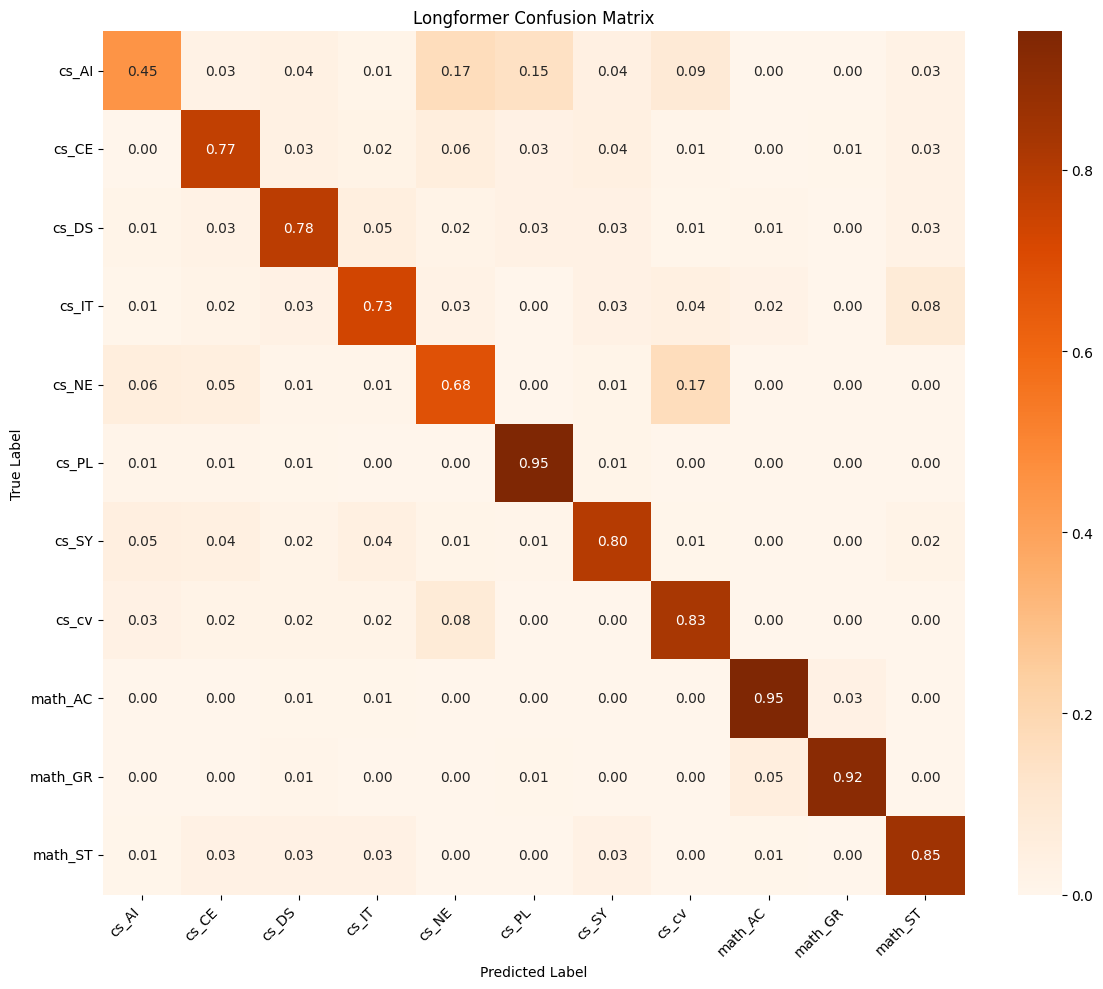

In [11]:
# 获取预测结果
predictions = trainer.predict(encoded_eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# 计算混淆矩阵
cm = confusion_matrix(labels, preds)
cm_normalized = confusion_matrix(labels, preds, normalize='true')

# 获取标签名称
label_names = unique_labels



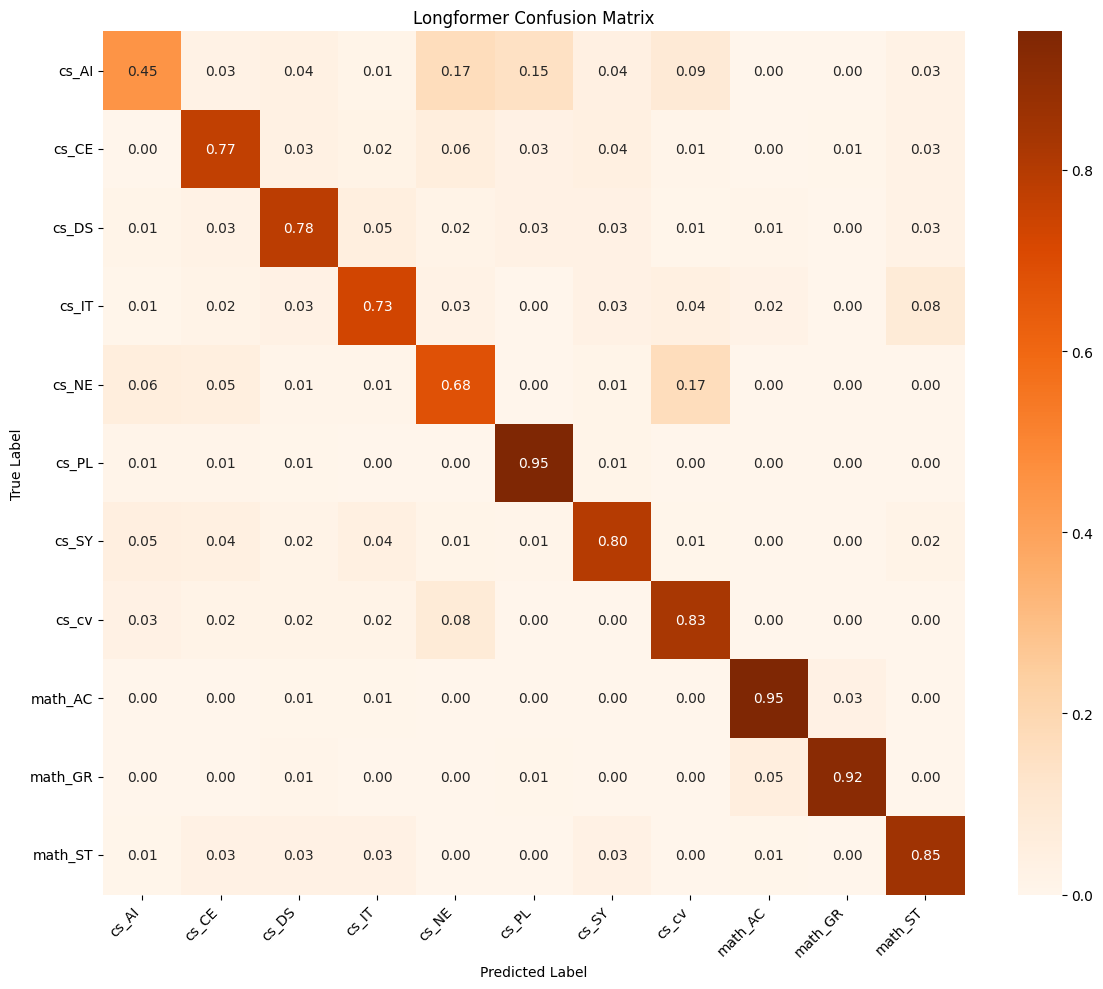

In [14]:
# 绘制混淆矩阵
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", xticklabels=label_names, yticklabels=label_names, cmap='Oranges')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Longformer Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('./results/(test)Longformer Confusion Matrix.pdf')
plt.savefig('./results/Longformer_Confusion_Matrix.pdf')
plt.show()

In [13]:
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=label_names))

# 计算并打印 Macro F1
macro_f1 = f1_score(labels, preds, average='macro')
print(f"Macro F1 Score: {macro_f1:.4f}")

report = classification_report(labels, preds, target_names=label_names, output_dict=True)  # 使用 output_dict=True 生成字典
print("\nClassification Report:")
print(report)

# 转换分类报告为 DataFrame
df_report = pd.DataFrame(report).transpose()

# 添加 Macro F1 到分类报告
df_report.loc['macro_f1'] = {'precision': None, 'recall': None, 'f1-score': macro_f1, 'support': None}

# 指定 CSV 文件路径
#output_csv_path = './results/(test)Longformer_classification_report.csv'
output_csv_path = './results/Longformer_classification_report.csv'

# 保存为 CSV 文件
df_report.to_csv(output_csv_path, index=True)
print(f"Classification report has been saved to {output_csv_path}")


Classification Report:
              precision    recall  f1-score   support

       cs_AI       0.72      0.45      0.56       300
       cs_CE       0.77      0.77      0.77       297
       cs_DS       0.80      0.78      0.79       300
       cs_IT       0.79      0.73      0.76       297
       cs_NE       0.64      0.68      0.66       300
       cs_PL       0.80      0.95      0.87       298
       cs_SY       0.79      0.80      0.79       297
       cs_cv       0.72      0.83      0.77       298
     math_AC       0.91      0.95      0.93       298
     math_GR       0.95      0.92      0.94       297
     math_ST       0.82      0.85      0.84       300

    accuracy                           0.79      3282
   macro avg       0.79      0.79      0.79      3282
weighted avg       0.79      0.79      0.79      3282

Macro F1 Score: 0.7883

Classification Report:
{'cs_AI': {'precision': 0.7157894736842105, 'recall': 0.4533333333333333, 'f1-score': 0.5551020408163265, 'support':

C:\Users\DreamDreamer\AppData\Local\Temp\ipykernel_61920\2043884668.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_report.loc['macro_f1'] = {'precision': None, 'recall': None, 'f1-score': macro_f1, 'support': None}
